In [2]:
import numpy as np
import json
import seaborn as sns 
import pandas as pd 
import pathlib
from matplotlib import pyplot as plt 
from collections import defaultdict
import re 

from data import get_source_triggers, split_by_intent

colors = ['#7f3b08','#b35806','#e08214','#fdb863','#8e0152','#d73027','#4575b4','#b2abd2','#8073ac','#542788','#2d004b']
intents_and_functions = ['radio', "FindManager", 'email_q', "Tomorrow", 'email_qc', "PlaceHasFeature", 'quirky', "DoNotConfirm", 'traffic', "FenceAttendee", "total"]
color_mapping = {k:v for k,v in zip(intents_and_functions, colors)}

marker_lookup = {'radio': "d", "FindManager": "o", 'email_q': "H", "Tomorrow": "P", 'email_qc': "^", "PlaceHasFeature": ">", 'quirky': "s", "DoNotConfirm": "<", 'traffic': "8", "FenceAttendee": "p", "total": "D"}

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
def get_data_prob(intent_of_interest, data_dir, n_data, n_intent, trigger_tokens=None, starts=False, equals=False):
    train_data, __, __ = split_by_intent(data_dir, intent_of_interest, n_data, n_intent)

    if trigger_tokens is None: 
        trigger_tokens = get_source_triggers(train_data, intent_of_interest)

    #print(trigger_tokens)
    count_output_has_fxn = 0
    count_input_has_trigger = 0
    count_output_has_fxn_and_input_has_trigger= 0
    #for i, (src_l, tgt_l) in enumerate(zip(src_lines, tgt_lines)):
    for example in train_data:
        src_l = re.split("\s+", example['text'])
        tgt_l = example['label']
        has_trigger = False
        has_fxn = False 
        for tok in trigger_tokens:
            if not starts and not equals:
                if tok in [x.lower() for x in src_l]:
                    has_trigger = True
                    break
            elif equals and not starts:
                if " ".join(tok).lower() == " ".join(src_l).lower():
                    has_trigger = True
                    break
            else:
                if src_l[0].lower() == tok: 
                    has_trigger = True
                    break
        if intent_of_interest in [int(tgt_l)]:
            has_fxn = True
        if has_trigger:
            count_input_has_trigger += 1
        if has_trigger and has_fxn:
            count_output_has_fxn += 1
        if has_trigger and has_fxn:
            count_output_has_fxn_and_input_has_trigger += 1
    
    prob_fxn_given_trigger = count_output_has_fxn_and_input_has_trigger / (count_input_has_trigger)
    prob_trigger_given_fxn = count_output_has_fxn_and_input_has_trigger / (count_output_has_fxn)

    return prob_fxn_given_trigger, prob_trigger_given_fxn


def get_model_prob(intent, checkpoint_dir):
    checkpoint_dir = pathlib.Path(checkpoint_dir)
    with open(checkpoint_dir.joinpath("test_predictions.json")) as f1:
        pred_data = json.load(f1) 
    model_probs = []
    for example in pred_data:
        if int(example['true']) == intent: 
            p_label = example['pred'][intent]
            model_probs.append(p_label)
    return np.mean(model_probs)

In [4]:

df = pd.DataFrame(columns=['function', 'examples', 'seed', 'split', 'prob', 'type'], dtype=object)

num_to_name = {50: "radio", 15: "email_q", 16: "email_qc", 27: "quirky", 66: "traffic"} 

for fxn in [50, 15, 16, 27, 66]:
    for seed in [12, 31, 64]: 
    # for seed in [12]: 
        for fxn_split in [15, 30, 75]:
            for split in ["750", "1500", "3000", "7500", "15000", "18000"]:
                try:
                    data_prob, __ = get_data_prob(fxn, "/home/estengel/incremental-function-learning/intent/data/nlu_eval_data/", n_data = int(split), n_intent = fxn_split)
                    model_prob = get_model_prob(fxn, f"//brtx/606-nvme1/estengel/intent_fixed_test/intent_no_shuffle/{fxn}/{seed}_seed/{split}_{fxn_split}/")
                except FileNotFoundError:
                    print(f"//brtx/606-nvme1/estengel/intent_fixed_test/intent_no_shuffle/{fxn}/{seed}_seed/{split}_{fxn_split}/")

                df = df.append({"function": num_to_name[fxn], "examples": fxn_split, "seed": seed, "split": split, "prob": data_prob, "type": "data"}, ignore_index=True)
                df = df.append({"function": num_to_name[fxn], "examples": fxn_split, "seed": seed, "split": split, "prob": model_prob, "type": "model"}, ignore_index=True)
        

There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
There are 57 instances of 50 in dev and 116 in test
//brtx/606-nvme1/estengel/intent_fixed_test/intent_no_shuffle/50/12_seed/750_75/
There are 57 instances of 50 in dev and 116 in test
//brtx/606-nvme1/estengel/intent_fixed_test/intent_no_shuffle/50/12_seed/1500_75/
There are 57 instances of 50 in dev and 116 in test
//brtx/606-nvme1/estengel/intent_fixed_test/intent_no_shu

In [7]:
def read_calflow_beam_file(path, beam_size=100):
    # turns out output is interleaved? 
    with open(path) as f1:
        lines = [x.strip().split(" ") for x in f1.readlines()]

    outputs = {i: [] for i in range(len(lines)//beam_size)}
    for i in range(len(lines)):
        orig_idx = i % (len(lines) // beam_size) 
        outputs[orig_idx].append(lines[i])

    for idx, l in outputs.items():
        try:
            assert(len(l) == beam_size)
        except AssertionError:
            print(len(l))
            print(idx)
            raise AssertionError()
    return outputs 

def read_calflow_input_file(path): 
    with open(path) as f1:
        return [x.strip().split(" ") for x in f1.readlines()]

def get_calflow_data_prob(train_path, fxn_of_interest, trigger_tokens, starts=False, equals=False):
    with open(train_path.joinpath("train.src_tok")) as src_f, open(train_path.joinpath("train.tgt")) as tgt_f:
        src_lines = [x.strip().split(" ") for x in src_f.readlines()]
        tgt_lines = [x.strip().split(" ") for x in tgt_f.readlines()]

    # remove context  
    for i, line in enumerate(src_lines):
        user_idxs = [j for j, tok in enumerate(line) if tok == "__User"]
        line = line[user_idxs[-1]+1:]
        src_lines[i] = line

    count_output_has_fxn = 0
    count_input_has_trigger = 0
    count_output_has_fxn_and_input_has_trigger= 0
    for i, (src_l, tgt_l) in enumerate(zip(src_lines, tgt_lines)):
        has_trigger = False
        has_fxn = False 
        for tok in trigger_tokens:
            if not starts and not equals:
                if tok in [x.lower() for x in src_l]:
                    has_trigger = True
                    break
            elif equals and not starts:
                if " ".join(tok).lower() == " ".join(src_l).lower():
                    has_trigger = True
                    break
            else:
                if src_l[0].lower() == tok: 
                    has_trigger = True
                    break
        if fxn_of_interest in tgt_l:
            has_fxn = True
        if has_trigger:
            count_input_has_trigger += 1
        if has_trigger and has_fxn:
            count_output_has_fxn += 1
        if has_trigger and has_fxn:
            count_output_has_fxn_and_input_has_trigger += 1

        if not has_fxn and has_trigger:
            print(" ".join(src_l))
            print(" ".join(tgt_l))


    prob_fxn_given_trigger = count_output_has_fxn_and_input_has_trigger / (count_input_has_trigger)
    prob_trigger_given_fxn = count_output_has_fxn_and_input_has_trigger / (count_output_has_fxn)

    return prob_fxn_given_trigger, prob_trigger_given_fxn

def get_calflow_beam_prob(inputs, beam_predictions, fxn_of_interest):
    beam_probs = []

    for i, inp, plan in inputs: 
        all_preds = beam_predictions[i]
        # print(" ".join(inp))
        # print(" ".join(all_preds[0]))
        split_preds = [re.split("[ \(\)]", " ".join(p)) for p in all_preds]
        all_has_fxn = [1 if fxn_of_interest in pred else 0 for pred in split_preds]
        num_fxn_of_interest = sum(all_has_fxn)
        total = len(all_preds) 
        beam_probs.append(num_fxn_of_interest/total)

    return beam_probs

def get_calflow_inputs_of_interest(path, fxn_of_interest): 
    src_path = path.joinpath("fxn_test_valid.src_tok")
    tgt_path = path.joinpath("fxn_test_valid.tgt")

    src_lines = read_calflow_input_file(src_path)
    tgt_lines = read_calflow_input_file(tgt_path)

    pairs_of_interest = [(i, src_l, tgt_l) for i, (src_l, tgt_l) in enumerate(zip(src_lines, tgt_lines)) if fxn_of_interest in tgt_l]

    return pairs_of_interest


def main(path, pred_path, fxn_of_interest, trigger_tokens, beam_size=100, starts = False):
    p_fxn_given_trigger, __ = get_data_prob(path, fxn_of_interest, trigger_tokens, starts=starts)
    pairs_of_interest = get_calflow_inputs_of_interest(path, fxn_of_interest)

    beam_preds = read_calflow_beam_file(pred_path, beam_size) 
    # print("\n".join([" ".join(x) for x in beam_preds[0][0:3]]))
    # print("\n".join([" ".join(x) for x in beam_preds[0][-3:]]))
    beam_probs = get_calflow_beam_prob(pairs_of_interest, beam_preds, fxn_of_interest) 

    return (p_fxn_given_trigger, np.mean(beam_probs))





In [8]:
%%capture

fxn_list = [("FindManager", "smcalflow_samples_curated", ["manager", "boss", "supervisor"]),
            ("Tomorrow", "smcalflow_samples_curated", ["tomorrow"]),
            ("DoNotConfirm", "smcalflow_samples_big", ["cancel", "n't", "no"]),
            ("PlaceHasFeature", "smcalflow_samples", ["takeout", "casual", "waiter"]),
            ("FenceAttendee", "smcalflow_samples_curated", ["meet","mom"])]


calflow_df = pd.DataFrame(columns=["fxn", "train", "examples", "seed", "prob", "type"], dtype=object)

for fxn, path, triggers in fxn_list:
    for split in ["5000", "10000", "20000", "50000", "100000", "max"]:
        for seed in [12, 31, 64]:
            data_path = pathlib.Path(f"/brtx/601-nvme1/estengel/resources/data/{path}/{fxn}/{split}_100")
            # pred_path = pathlib.Path(f"/home/t-eliass/amlt_models/transformer/nfirm_{seed}_seed/{split}_100/translate_output/fxn_test_valid_top_100.tgt")
            #triggers = ["no"]
            data_prob, __ = get_calflow_data_prob(data_path, fxn, triggers) 
            #data_prob, beam_prob_estimate = main(data_path, pred_path, "DoNotConfirm", triggers, 100, starts=True, equals=False)
            calflow_df = calflow_df.append({"fxn": fxn, "train": split, "examples": 100, "seed": seed, "type": "data", "prob": data_prob}, ignore_index=True)

/brtx/601-nvme1/estengel/miniconda3/envs/miso_new/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
/brtx/601-nvme1/estengel/miniconda3/envs/miso_new/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator


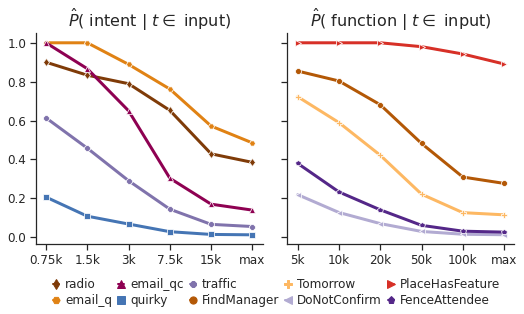

In [17]:
from matplotlib.legend_handler import HandlerLine2D

fig, ax = plt.subplots(1, 2, figsize=(6.5, 3.5), sharey=True, sharex=False)

sns.set(context='paper')
sns.set(font_scale = 1.09)
sns.set_style(style='ticks')

def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(2)

handler_map={plt.Line2D : HandlerLine2D(update_func=update)}

legend_kws_intent = dict(ncol=2, borderpad=0.0, labelspacing=0.2, columnspacing=0.5, handlelength=0.5,
                bbox_to_anchor=(0.78, -0.15), loc=1, handletextpad=0.5, handler_map=handler_map, frameon=False)


sub_df = df[df['examples'] == 30]
sub_df = sub_df[sub_df['type'] == 'data']
# sub_df = sub_df[sub_df['seed'] == 64]

sns.lineplot(data=sub_df, 
             x="split", 
             y="prob", 
             hue="function", 
             style="function",
             err_style=None,
             dashes=False,
             markers=marker_lookup,
             linewidth=3, 
             size=5,
             palette = color_mapping, 
             ax = ax[0])
sns.despine()
ax[0].set_title(r"$\hat{P}($ intent | $t \in$ input$)$", fontsize=16)
# ax[0].set_xlabel("Total train")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

# ax[0].legend(**legend_kws_intent)
ax[0].get_legend().remove()
ax[0].set_xticklabels(['0.75k', '1.5k', '3k', '7.5k', '15k', 'max'])

sub_calflow_df = calflow_df[calflow_df['examples'] == 100]
sub_calflow_df = sub_calflow_df[sub_calflow_df['type'] == 'data']

legend_kws_calflow = dict(ncol=2, borderpad=0.0, labelspacing=0.2, columnspacing=0.5, handlelength=0.5,
                bbox_to_anchor=(1.05, -0.15), loc=1, handletextpad=0.5, handler_map=handler_map, frameon=False)

sns.lineplot(data=sub_calflow_df, 
             x="train", 
             y="prob", 
             hue="fxn", 
             style="fxn",
             dashes=False,
             markers=marker_lookup,
             linewidth=3, 
             size=5,
             palette = color_mapping, 
             ax = ax[1])
sns.despine()
ax[1].set_title(r"$\hat{P}($ function | $t\in$ input$)$", fontsize=16)
# ax[1].set_xlabel("Total train")
ax[1].set_xlabel("")
ax[1].get_legend().remove()
ax[1].set_ylabel("")
ax[1].set_xticklabels(['5k', '10k', '20k', '50k', '100k', 'max'])

lines1, handles1 = ax[0].get_legend_handles_labels()
lines2, handles2 = ax[1].get_legend_handles_labels()

lines_and_handles = zip(lines1, handles1)
lines_and_handles = [x for x in lines_and_handles if x[1] != 'Overall']
lines1, handles1 = [list(x) for x in zip(*lines_and_handles)]

lines = lines1+lines2
handles = handles1 + handles2


legend_kws = dict(ncol=5, frameon=False, borderpad=0.0, labelspacing=0.2, columnspacing=0.5, handlelength=0.5, markerscale=1.2,
                bbox_to_anchor=(0.95, 0.03), loc=1, handletextpad=0.5, handler_map=handler_map)
plt.figlegend(lines, handles, **legend_kws)
plt.tight_layout()
plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/prob_data.pdf") 